In [1]:
# GP imports
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import copy
# Make plots inline
%matplotlib inline

# AutoEncoder imports
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.AutoEncoder import EncoderBig, DecoderBig, EncoderHuge, DecoderHuge
from scripts.utils import train_keys, target_keys, ScaleData

### Load Training Data

In [2]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-16/experiment_name=0-epoch=163-val_loss=0.03.ckpt"
# modelAE = AutoEncoder.load_from_checkpoint(path, encoder = EncoderHuge, decoder = DecoderHuge,
#                                          n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.001)
# encoder = modelAE.encoder

In [3]:
train_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
valid_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"

train = pd.read_pickle(train_path) 
valid = pd.read_pickle(valid_path)

In [4]:
train_target = train['target']

### Data Processing

In [5]:
scaler = StandardScaler()
train_scale = scaler.fit_transform(train)
valid_scale = scaler.transform(valid)
train_scale = train_scale[:,:-1]
valid_scale = valid_scale[:,:-1]

In [6]:
train_scale = pd.DataFrame(train_scale, columns = train_keys+target_keys)
valid_scale = pd.DataFrame(valid_scale, columns = train_keys+target_keys)

In [7]:
def dropNan(df, feature):
    keys = copy.deepcopy(train_keys)
    keys.append(feature)
    df = df[keys].dropna()
    
    return df

### Model Definitions

In [8]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, feature_extractor,train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.feature_extractor = feature_extractor
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3)),
                num_dims=3, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
def train(training_iterations, model,  train_x, train_y):
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

In [10]:
def getAE(path):
    modelAE = AutoEncoder.load_from_checkpoint(path, encoder = EncoderHuge,
                                               decoder = DecoderHuge,n_input = 15,
                                               batch_size = 2048, epochs = 150,
                                               learning_rate = 0.001)
    return modelAE.encoder

In [11]:
leading_fluxes = [
    "efeetg_gb",
    "efetem_gb",
    "efiitg_gb",
]

In [12]:
n = 10_000

In [13]:
results_dict = {}
for flux in leading_fluxes:
    
    # Get Fresh AutoEncoder
    AE = getAE(path)
    
    # Remove NaNs according to current flux
    train_data = dropNan(train_scale, flux)
    
    idx = np.random.permutation(train_data.shape[0])[:n]
    
    train_x = train_data[train_keys].iloc[idx]
    train_y = train_data[flux].iloc[idx]
    
    train_x = torch.tensor(train_x.to_numpy()).cuda()
    train_y = torch.tensor(train_y.to_numpy()).cuda()
    
    train_x = train_x.float()
    train_y = train_y.float()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(AE, train_x, train_y, likelihood)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    training_iterations = 60

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.feature_extractor.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    %time train(training_iterations, model, train_x, train_y)
    
    # Get Validation Data
    valid_data = dropNan(valid_scale, flux)
    
    valid_x = torch.tensor(valid_data[train_keys].to_numpy()).cuda()
    valid_x = valid_x[:10_000]
    
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(valid_x.float())
        means = preds.mean.cpu()
        variance = preds.variance.cpu()
        
    
        results_dict[flux] = {"means": means.detach().numpy(), "variances": variance.detach().numpy()}

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 42.7 s, sys: 13.3 s, total: 56.1 s
Wall time: 56.3 s


/home/tmadula/.conda/envs/UKAEA/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 42 s, sys: 13 s, total: 55 s
Wall time: 55.2 s


  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 41.2 s, sys: 12.7 s, total: 53.9 s
Wall time: 54.1 s


efeetg_gb: 0.8901062929112389
efetem_gb: 0.9369646203394361
efiitg_gb: 0.6988713108925813


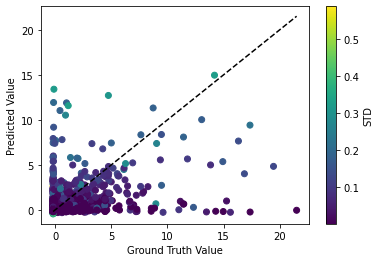

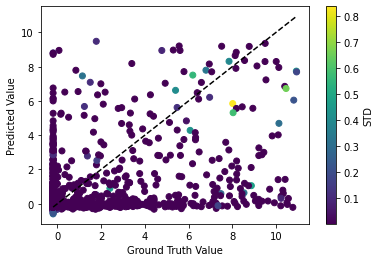

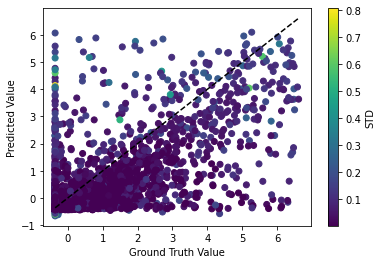

In [14]:
for flux in leading_fluxes: 
    valid_data = dropNan(valid_scale, flux).iloc[:10_000]
    truth = valid_data[flux]
    x = np.linspace(truth.min(), truth.max(), 100)
    mean = results_dict[flux]['means']
    std = np.sqrt(results_dict[flux]['variances'])
    plt.figure()
    plt.scatter(truth, mean, c = std)
    plt.plot(x,x, color = 'black', ls ='--')
    plt.colorbar(label = 'STD')
    plt.xlabel('Ground Truth Value')
    plt.ylabel('Predicted Value')
    RMS = np.sqrt(np.sum((mean - truth)**2)/10_000)
    print(f'{flux}: {RMS}')

In [16]:
rms_data = pd.read_csv("/home/tmadula/data/UKAEA/RMS.csv")

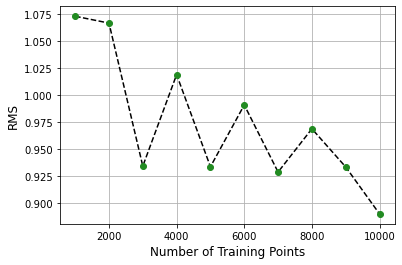

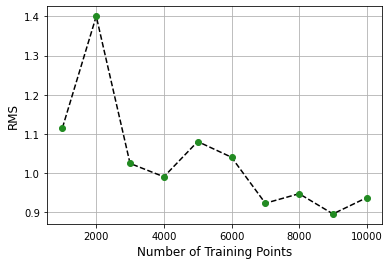

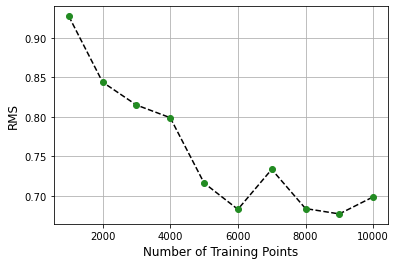

In [29]:
for flux in leading_fluxes: 
    plt.figure()
    plt.plot(rms_data['Data Points'], rms_data[flux], ls ='--', c = 'black')
    plt.plot(rms_data['Data Points'], rms_data[flux], '.', ms=12, c ='forestgreen')
    plt.xlabel('Number of Training Points', fontsize = 12)
    plt.ylabel('RMS', fontsize = 12)
    plt.grid(which = 'both')
    